In [ ]:
%pip install -r ../requirements.txt

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants
SAMPLE_RATE = 44100
N_MELS = 128
TIME_STEPS = 128
MIC_POSITIONS = torch.tensor([  # Hexagonal array (shape: [3, 6])
    [0.0, 0.0, 0.0],      # Mic 1 (center)
    [1.5, 0.0, 0.0],      # Mic 2 (right)
    [0.75, 1.299, 0.0],   # Mic 3 (top-right)
    [-0.75, 1.299, 0.0],  # Mic 4 (top-left)
    [-1.5, 0.0, 0.0],     # Mic 5 (left)
    [-0.75, -1.299, 0.0]  # Mic 6 (bottom-left)
], dtype=torch.float32).T
SPEED_OF_SOUND = 343.0
DATA_DIR = "../data/simulations/"

#### Data loading & pre-processing

In [3]:
class GunshotDataset(Dataset):
    def __init__(self, sim_dirs, labels):
        self.sim_dirs = sim_dirs
        self.labels = labels

    def __len__(self):
        return len(self.sim_dirs)

    def __getitem__(self, idx):
        # Load and convert to fixed-size spectrogram
        specs = []
        for mic in range(1, 7):
            audio, _ = librosa.load(
                f"{self.sim_dirs[idx]}/mic_{mic}_recording.wav",
                sr=SAMPLE_RATE
            )
            S = librosa.feature.melspectrogram(
                y=audio,
                sr=SAMPLE_RATE,
                n_mels=N_MELS,
                n_fft=2048,
                hop_length=len(audio)//(TIME_STEPS-1)
            )
            S = librosa.power_to_db(S, ref=np.max)
            S = torch.tensor(S, dtype=torch.float32)
            # Pad/truncate to 128x128
            if S.shape[1] < TIME_STEPS:
                S = torch.nn.functional.pad(S, (0, TIME_STEPS-S.shape[1]))
            else:
                S = S[:, :TIME_STEPS]
            specs.append(S)
        # Stack to [6, 128, 128] -> permute to [128, 128, 6]
        X = torch.stack(specs).permute(1, 2, 0)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return X, y

# Load data
labels = pd.read_csv(f"{DATA_DIR}/labels.csv")
sim_dirs = [f"{DATA_DIR}/gunshot_{i}" for i in range(len(labels))]
X_train, X_test, y_train, y_test = train_test_split(
    sim_dirs, labels[["distance", "azimuth", "elevation"]].values,
    test_size=0.2, random_state=42
)

train_dataset = GunshotDataset(X_train, y_train)
test_dataset = GunshotDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Spectogram PINN model

In [7]:
class SpectrogramPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: [batch, 6, 128, 128]
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)  # [batch, 32, 128, 128]
        self.pool = nn.MaxPool2d(2)  # [batch, 32, 64, 64]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # [batch, 64, 64, 64]
        self.pool2 = nn.MaxPool2d(2)  # [batch, 64, 32, 32]  ⚠️ MISSING POOLING LAYER
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # ⚠️ CORRECTED DIMENSION (64*32*32=65536)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # [batch, 6, 128, 128]
        x = self.pool(torch.relu(self.conv1(x)))  # [batch, 32, 64, 64]
        x = self.pool2(torch.relu(self.conv2(x)))  # [batch, 64, 32, 32] ⚠️ ADDED POOL2
        x = torch.flatten(x, 1)  # [batch, 64*32*32=65536]
        x = torch.relu(self.fc1(x))  # [batch, 128]
        return self.fc2(x)  # [batch, 3]

#### Physics Informed Loss

In [11]:
def physics_loss(y_pred, mic_positions=MIC_POSITIONS):
    """TDoA loss using predicted coordinates and spectrogram phase differences."""
    distance, azimuth, elevation = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    
    # --- 1. Predicted TDoA from geometry ---
    # Convert polar to Cartesian (relative to mic1)
    x = distance * torch.cos(azimuth) * torch.cos(elevation)
    y = distance * torch.sin(azimuth) * torch.cos(elevation)
    z = distance * torch.sin(elevation)
    source_pos = torch.stack([x, y, z], dim=1)  # [batch, 3]
    
    # Calculate expected TDoA
    distances = torch.norm(mic_positions - source_pos.unsqueeze(2), dim=1)  # [batch, 6]
    tdoa_geom = (distances - distances[:, 0:1]) / SPEED_OF_SOUND  # [batch, 6]
    
    # --- 2. Approximate TDoA from spectrogram phase ---
    # Placeholder: Replace with actual phase difference calculation
    # For now, use a simple proxy (e.g., time delays from waveform cross-correlation)
    tdoa_spectro = torch.zeros_like(tdoa_geom[:, 1:])  # [batch, 5]
    
    return torch.mean((tdoa_geom[:, 1:] - tdoa_spectro)**2)  # Skip mic1 (reference)

#### Training loop

In [12]:
def train(model, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = hybrid_loss(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Initialize
model = SpectrogramPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

# Train
train(model, train_loader)

Epoch 1/5, Loss: 9036.4711
Epoch 2/5, Loss: 4872.5218
Epoch 3/5, Loss: 4261.3905
Epoch 4/5, Loss: 4133.6181
Epoch 5/5, Loss: 3917.3944


#### Evaluation

In [13]:
def evaluate(model, dataloader):
    model.eval()
    distance_errors = []
    azimuth_errors = []
    elevation_errors = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            y_pred = model(X_batch)
            # Distance error (meters)
            distance_errors.extend(torch.abs(y_pred[:,0] - y_batch[:,0]).tolist())
            # Angular errors (degrees)
            azimuth_errors.extend(torch.abs(y_pred[:,1] - y_batch[:,1]).mul(180/np.pi).tolist())
            elevation_errors.extend(torch.abs(y_pred[:,2] - y_batch[:,2]).mul(180/np.pi).tolist())
    
    print(f"Mean Distance Error: {np.mean(distance_errors):.2f} m")
    print(f"Mean Azimuth Error: {np.mean(azimuth_errors):.2f}°")
    print(f"Mean Elevation Error: {np.mean(elevation_errors):.2f}°")

evaluate(model, test_loader)

Mean Distance Error: 1.34 m
Mean Azimuth Error: 4093.39°
Mean Elevation Error: 476.99°


In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(model, dataloader):
    model.eval()
    distance_errors = []
    azimuth_errors = []
    elevation_errors = []
    pos_errors = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            y_pred = model(X_batch)
            
            # Distance error (meters)
            distance_errors.extend(torch.abs(y_pred[:, 0] - y_batch[:, 0]).tolist())
            
            # Angular errors (degrees)
            azimuth_errors.extend(torch.abs(y_pred[:, 1] - y_batch[:, 1]).mul(180/np.pi).tolist())
            elevation_errors.extend(torch.abs(y_pred[:, 2] - y_batch[:, 2]).mul(180/np.pi).tolist())
            
            # 3D position error (convert polar to Cartesian)
            def polar_to_cartesian(r, theta, phi):
                x = r * torch.cos(theta) * torch.cos(phi)
                y = r * torch.sin(theta) * torch.cos(phi)
                z = r * torch.sin(phi)
                return torch.stack([x, y, z], dim=1)
            
            pos_true = polar_to_cartesian(y_batch[:, 0], y_batch[:, 1], y_batch[:, 2])
            pos_pred = polar_to_cartesian(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])
            pos_errors.extend(torch.norm(pos_true - pos_pred, dim=1).tolist())
    
    # Calculate metrics
    metrics = {
        'distance_mae': np.mean(distance_errors),
        'distance_rmse': np.sqrt(mean_squared_error(y_batch[:, 0], y_pred[:, 0])),
        'azimuth_mae': np.mean(azimuth_errors),
        'elevation_mae': np.mean(elevation_errors),
        '3d_pos_mae': np.mean(pos_errors),
        'angular_acc_5deg': np.mean(np.array(azimuth_errors) < 5),  # % within 5°
        'distance_acc_1m': np.mean(np.array(distance_errors) < 1),  # % within 1m
    }
    return metrics

# Usage
metrics = evaluate_model(model, test_loader)
for k, v in metrics.items():
    print(f"{k:>15}: {v:.4f}")

   distance_mae: 1.3422
  distance_rmse: 1.6108
    azimuth_mae: 4093.3893
  elevation_mae: 476.9885
     3d_pos_mae: 2.6682
angular_acc_5deg: 0.0000
distance_acc_1m: 0.4000


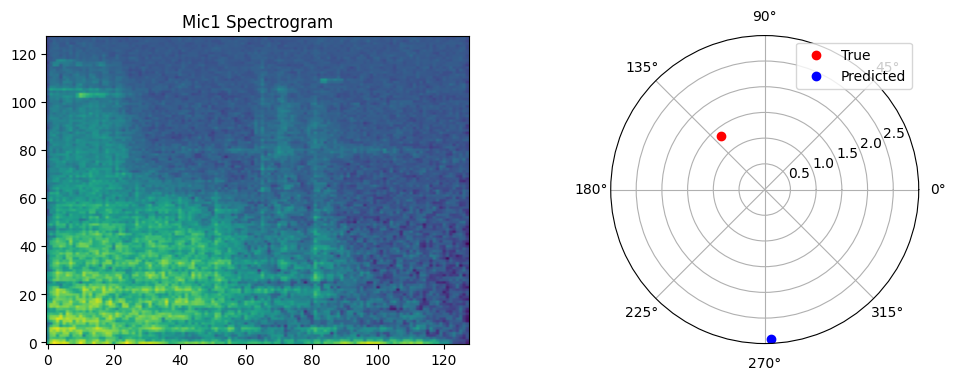

In [14]:
# Plot sample prediction
def plot_sample(model, dataset, idx=0):
    X, y_true = dataset[idx]
    with torch.no_grad():
        y_pred = model(X.unsqueeze(0))
    
    plt.figure(figsize=(12, 4))
    # Spectrogram
    plt.subplot(1, 2, 1)
    plt.imshow(X[:,:,0], aspect='auto', origin='lower')
    plt.title("Mic1 Spectrogram")
    # Polar coordinates
    plt.subplot(1, 2, 2, polar=True)
    plt.scatter(y_true[1], y_true[0], c='r', label="True")
    plt.scatter(y_pred[0,1], y_pred[0,0], c='b', label="Predicted")
    plt.legend()

plot_sample(model, test_dataset)